In [1]:
# Create a list of required packages
needed_packages <- c("dplyr", "tidyverse", "ggplot2", "countrycode", "zoo", "ggrepel", "reshape2", "here", "maps", "mapproj", "sf")

# Extract not installed packages
not_installed <- needed_packages[!(needed_packages %in% installed.packages()[ , "Package"])]

# Install not installed packages
if(length(not_installed)) install.packages(not_installed)

In [2]:
library(dplyr)
library(tidyverse)
library(ggplot2)
library(countrycode)
library(zoo)
library(ggrepel)
library(reshape2)
library(maps)
library(mapproj)
library(sf)
library(here)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v forcats   1.0.0     v readr     2.1.4
v ggplot2   3.4.2     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths



Att

# Pre-processing

## Hospital Beds Data

First we will read the CSV file.

In [3]:
# Read the csv file
beds_df <- read.csv("API_SH.MED.BEDS.ZS_DS2_en_csv_v2_5363904.csv", sep = ',', skip = 4, header = T)

# Display the dimension
dim(beds_df)

# Check the first few rows
head(beds_df)

[1] 266  67

,Country.Name,Country.Code,Indicator.Name,Indicator.Code,X1960,X1961,X1962,X1963,X1964,X1965,...,X2013,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
1,Aruba,ABW,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Africa Eastern and Southern,AFE,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,1.9664425,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Afghanistan,AFG,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,0.1706270,NA,NA,NA,NA,NA,...,0.53,0.5,0.5,0.5,0.39,NA,NA,NA,NA,NA
4,Africa Western and Central,AFW,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,0.7860573,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,Angola,AGO,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,2.0614617,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,Albania,ALB,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,5.1026759,NA,NA,NA,NA,NA,...,2.89,NA,NA,NA,NA,NA,NA,NA,NA,NA


Remove unnecessary data.

In [4]:
# Drop unnecessary columns, remove "X" from column names, and remove rows with Country.Code values that are not valid ISO-3 codes
beds_df <-
    beds_df %>%
    select(-c("Indicator.Name", "Indicator.Code", "X")) %>% # Drop unnecessary columns
    rename_with(~ sub("^X", "", .), starts_with("X")) %>% # Remove "X" from column names
    filter(Country.Code %in% codelist$iso3c) # Remove rows with Country.Code values that are not valid ISO-3 codes

# Check the first few rows
head(beds_df)

,Country.Name,Country.Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
1,Aruba,ABW,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Afghanistan,AFG,0.170627,NA,NA,NA,NA,NA,NA,NA,...,0.53,0.53,0.5,0.5,0.50,0.39,NA,NA,NA,NA
3,Angola,AGO,2.061462,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Albania,ALB,5.102676,NA,NA,NA,NA,NA,NA,NA,...,2.88,2.89,NA,NA,NA,NA,NA,NA,NA,NA
5,Andorra,AND,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,United Arab Emirates,ARE,NA,NA,NA,NA,NA,NA,NA,NA,...,1.07,1.15,NA,1.1,1.36,1.38,NA,NA,NA,NA


We also want to remove columns where there are no data for Ireland, since it's the focus of this report. Luckily there are consecutive data for Ireland between 1980 and 2018.

In [5]:
# List the column names where the data is NA for Ireland
ireland_row <- which(beds_df$Country.Name == "Ireland")
colnames(beds_df)[is.na(beds_df[ireland_row, ])]

# Drop columns where the data is NA for Ireland
beds_df <-
    beds_df %>%
    select(-which(is.na(.[ireland_row, ])))

# Check the first few rows
head(beds_df)

[1] "1960" "1961" "1962" "1963" "1964" "1965" "1966" "1967" "1968" "1969"
[11] "1970" "1971" "1972" "1973" "1974" "1975" "1976" "1977" "1978" "1979"
[21] "2019" "2020" "2021"

,Country.Name,Country.Code,1980,1981,1982,1983,1984,1985,1986,1987,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Aruba,ABW,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Afghanistan,AFG,NA,0.2756,NA,NA,NA,NA,NA,0.3091,...,0.42,0.43,0.44,0.53,0.53,0.5,0.5,0.50,0.39,NA
3,Angola,AGO,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Albania,ALB,4.2717,4.1871,4.1607,4.0862,4.139,4.1388,4.0697,3.9700,...,3.01,2.99,2.88,2.88,2.89,NA,NA,NA,NA,NA
5,Andorra,AND,NA,NA,NA,NA,NA,NA,NA,NA,...,2.50,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,United Arab Emirates,ARE,2.8495,2.8751,NA,NA,NA,NA,NA,NA,...,1.93,1.93,1.07,1.07,1.15,NA,1.1,1.36,1.38,NA


Drop countries that are missing more than 30% of the columns, and restructure the dataframe.

In [6]:
# Drop rows with more than 30% of missing data and restructure
beds_df <-
    beds_df %>%
    filter(rowSums(is.na(.)) <= 12)  %>% # Drop rows which contains more than 12 NAs (30% of the columns)
    pivot_longer(cols = matches("[0-9]+"), names_to = "Year", values_to = "Value") %>% # Make years into a column
    mutate(Year = as.integer(Year)) # Make `Year` into integer

# Check the number of missing values
sum(is.na(beds_df))

# Check the first few rows
head(beds_df)

[1] 255

Country.Name,Country.Code,Year,Value
<chr>,<chr>,<int>,<dbl>
Albania,ALB,1980,4.2717
Albania,ALB,1981,4.1871
Albania,ALB,1982,4.1607
Albania,ALB,1983,4.0862
Albania,ALB,1984,4.1390
Albania,ALB,1985,4.1388


In [7]:
# Group the dataframe by 'Country.Name' and imputate
beds_df <-
    beds_df %>%
    group_by(Country.Name) %>% # Group by 'Country.Name'
    mutate(Value = ifelse(is.na(Value), lag(Value), Value)) %>% # Fill the missing value with the previous value within the country
    mutate(Value = na.locf(Value, na.rm = FALSE)) %>% # Fill remaining missing values using LOCF
    mutate(Value = na.locf(Value, na.rm = FALSE, fromLast = TRUE)) %>% # Fill remaining missing values using NOCB
    mutate(across(Value, ~ round(., digits = 1))) %>% # Round `Value` to 1 decimal point
    ungroup() # Ungroup


# Check the number of missing values
sum(is.na(beds_df))

# Check the first few rows
head(beds_df)

[1] 0

Country.Name,Country.Code,Year,Value
<chr>,<chr>,<int>,<dbl>
Albania,ALB,1980,4.3
Albania,ALB,1981,4.2
Albania,ALB,1982,4.2
Albania,ALB,1983,4.1
Albania,ALB,1984,4.1
Albania,ALB,1985,4.1


## Hospital Nurses Wage Data

Read the CSV file with hospital nurses wage data.

In [8]:
# Read the csv file
wage_df <- read.csv("HEALTH_REAC_30042023221201143.csv", sep = ',', encoding = "UTF-8", header = T)

# Display the dimension
dim(wage_df)

# Check the first few rows
head(wage_df)

[1] 6215   11

,X.U.FEFF.VAR,Variable,UNIT,Measure,COU,Country,YEA,Year,Value,Flag.Codes,Flags
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>
1,RVNURINF,Remuneration of hospital nurses,YSALARMT,"Salaried, annual income, NCU",AUS,Australia,2010,2010,83705,D,Difference in methodology
2,RVNURINF,Remuneration of hospital nurses,YSALARMT,"Salaried, annual income, NCU",AUS,Australia,2011,2011,89235,D,Difference in methodology
3,RVNURINF,Remuneration of hospital nurses,YSALARMT,"Salaried, annual income, NCU",AUS,Australia,2012,2012,89971,D,Difference in methodology
4,RVNURINF,Remuneration of hospital nurses,YSALARMT,"Salaried, annual income, NCU",AUS,Australia,2013,2013,91232,D,Difference in methodology
5,RVNURINF,Remuneration of hospital nurses,YSALARMT,"Salaried, annual income, NCU",AUS,Australia,2014,2014,93042,D,Difference in methodology
6,RVNURINF,Remuneration of hospital nurses,YSALARMT,"Salaried, annual income, NCU",AUS,Australia,2015,2015,94991,D,Difference in methodology


In [9]:
# Filter the dataframe, drop unnecessary columns, and rename columns
wage1_df <-
    wage_df %>%
    filter(Variable == "Remuneration of hospital nurses"  & Measure == "Salaried, income per average wage" & Country %in% c("Australia", "New Zealand", "Ireland", "United States", "United Kingdom", "Canada")) %>% # Filter the dataframe
    select(c("COU", "Country", "Year", "Value")) %>% # Drop unnecessary columns
    rename(iso = COU, salary_usd = Value) # Rename columns

# Manually imputate a value for Australia: 2020
australia_2020 <- data.frame(iso = "AUS", Country = "Australia", Year = 2020, salary_usd = 1.32)
wage1_df <- rbind(wage1_df, australia_2020)
wage1_df <- wage1_df[order(wage1_df$iso, wage1_df$Country, wage1_df$Year), ]

# Display the dimension
dim(wage1_df)

# Check the first few rows
head(wage1_df)

[1] 66  4

,iso,Country,Year,salary_usd
,<chr>,<chr>,<dbl>,<dbl>
1,AUS,Australia,2010,1.21
2,AUS,Australia,2011,1.22
3,AUS,Australia,2012,1.19
4,AUS,Australia,2013,1.19
5,AUS,Australia,2014,1.18
6,AUS,Australia,2015,1.19


### Alternative Visualisation

Remove unnecessary data.

In [10]:
# Filter the dataframe, drop unnecessary columns, and rename columns
wage2_df <-
    wage_df %>%
    filter(Variable == "Remuneration of hospital nurses"  & Measure == "Salaried, income, US$ exchange rate") %>% # Filter the dataframe
    select(c("COU", "Country", "Year", "Value")) %>% # Drop unnecessary columns
    rename(iso = COU, salary_usd = Value) # Rename columns

# Display the dimension
dim(wage2_df)

# Check the first few rows
head(wage2_df)

[1] 356   4

,iso,Country,Year,salary_usd
,<chr>,<chr>,<int>,<dbl>
1,AUS,Australia,2010,76782.38
2,AUS,Australia,2011,92045.80
3,AUS,Australia,2012,93156.87
4,AUS,Australia,2013,88075.12
5,AUS,Australia,2014,83869.75
6,AUS,Australia,2015,71363.32


Read the CSV file with average wage data.

In [11]:
# Read the csv file
avg_df <- read.csv("AV_AN_WAGE_01052023095739437.csv", sep = ',', encoding = "UTF-8", header = T)

# Display the dimension
dim(avg_df)

# Check the first few rows
head(avg_df)

[1] 1166   15

,X.U.FEFF.COUNTRY,Country,SERIES,Series,TIME,Time,Unit.Code,Unit,PowerCode.Code,PowerCode,Reference.Period.Code,Reference.Period,Value,Flag.Codes,Flags
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<lgl>,<lgl>
1,AUS,Australia,CPNCU,Current prices in NCU,2010,2010,AUD,Australian Dollar,0,Units,NA,NA,69110.27,NA,NA
2,AUS,Australia,CPNCU,Current prices in NCU,2011,2011,AUD,Australian Dollar,0,Units,NA,NA,72978.60,NA,NA
3,AUS,Australia,CPNCU,Current prices in NCU,2012,2012,AUD,Australian Dollar,0,Units,NA,NA,75149.26,NA,NA
4,AUS,Australia,CPNCU,Current prices in NCU,2013,2013,AUD,Australian Dollar,0,Units,NA,NA,76598.34,NA,NA
5,AUS,Australia,CPNCU,Current prices in NCU,2014,2014,AUD,Australian Dollar,0,Units,NA,NA,78666.76,NA,NA
6,AUS,Australia,CPNCU,Current prices in NCU,2015,2015,AUD,Australian Dollar,0,Units,NA,NA,79206.80,NA,NA


Remove unnecessary data.

In [12]:
# Filter the dataframe, drop unnecessary columns, and rename columns
avg_df <-
    avg_df %>%
    filter(Series == "In 2021 constant prices at 2021 USD PPPs") %>% # Filter the dataframe
    select(c("X.U.FEFF.COUNTRY", "Country", "Time", "Value")) %>% # Drop unnecessary columns
    rename(iso = X.U.FEFF.COUNTRY, Year = Time, avg_usd = Value) # Rename columns

# Display the dimension
dim(avg_df)

# Check the first few rows
head(avg_df)

[1] 396   4

,iso,Country,Year,avg_usd
,<chr>,<chr>,<int>,<dbl>
1,AUS,Australia,2010,52645.06
2,AUS,Australia,2011,54341.63
3,AUS,Australia,2012,54693.53
4,AUS,Australia,2013,54493.43
5,AUS,Australia,2014,54959.00
6,AUS,Australia,2015,54594.29


Merge the two datasets.

In [13]:
# Merge `wage_df` and `avg_df`
nurse_df <-
    merge(wage2_df, avg_df, by = c("iso", "Country", "Year"))

# Shorten country names
nurse_df <-
    nurse_df %>%
        mutate(Country = case_when(
            Country == "United Kingdom" ~ "UK",
            Country == "United States" ~ "US",
            Country == "New Zealand" ~ "NZ",
            TRUE ~ Country
        ))

# Display the dimension
dim(nurse_df)

# Check the first few rows
head(nurse_df)

[1] 323   5

,iso,Country,Year,salary_usd,avg_usd
,<chr>,<chr>,<int>,<dbl>,<dbl>
1,AUS,Australia,2010,76782.38,52645.06
2,AUS,Australia,2011,92045.80,54341.63
3,AUS,Australia,2012,93156.87,54693.53
4,AUS,Australia,2013,88075.12,54493.43
5,AUS,Australia,2014,83869.75,54959.00
6,AUS,Australia,2015,71363.32,54594.29


## Hospital Waiting List Data

Read the CSV file with hospital waiting list data.

In [14]:
# Read the csv file
list_df <- read.csv("OpenData_IPDCNational01_2023.csv", sep = ',', header = T)

# Display the dimension
dim(list_df)

# Check the first few rows
head(list_df)

[1] 184   8

,ArchiveDate,Adult_Child,HospitalName,X0.6.Months,X6.12.Months,X12.18.Months,X18.Months..,Total
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
1,26/01/2023,Adult,Bantry General Hospital,59,41,21,5,126
2,26/01/2023,Adult,Beaumont Hospital,"3,998","1,515",228,29,"5,771"
3,26/01/2023,Adult,Cavan General Hospital,406,11,0,0,417
4,26/01/2023,Adult,Connolly Hospital Blanchardstown,"1,068",133,8,0,"1,209"
5,26/01/2023,Adult,Coombe Women and Infants University Hospital,138,41,8,2,189
6,26/01/2023,Adult,Cork University Hospital,830,279,145,247,"1,502"


In [15]:
# Convert `ArchiveDate` to Date format
list_df$ArchiveDate <-
    as.Date(list_df$ArchiveDate, format = "%d/%m/%Y")

# Filter the dataframe and drop unnecessary columns
list_df <-
    list_df %>%
    filter(ArchiveDate== as.Date("2023-03-30")) %>% # Filter the dataframe
    select(c("HospitalName", "Total")) # Drop unnecessary columns

# Display the dimension
dim(list_df)

# Check the first few rows
head(list_df)

[1] 61  2

,HospitalName,Total
,<chr>,<chr>
1,Bantry General Hospital,146
2,Beaumont Hospital,"6,599"
3,Cavan General Hospital,419
4,Connolly Hospital Blanchardstown,"1,105"
5,Coombe Women and Infants University Hospital,133
6,Cork University Hospital,"1,494"


In [16]:
# Convert 'Total' column to numerical
list_df$Total <-
    gsub(",", "", list_df$Total) %>% # Remove commas from 'Total' column
    as.numeric(list_df$Total) # Convert to numeric

# Group by HospitalName and calculate the sum of `Total`
list_df <-
    list_df %>%
    group_by(HospitalName) %>%
    summarise(total_list = sum(Total, na.rm = TRUE))

# Display the dimension
dim(list_df)

# Check the first few rows
head(list_df)

[1] 44  2

HospitalName,total_list
<chr>,<dbl>
Bantry General Hospital,146
Beaumont Hospital,6624
Cavan General Hospital,419
Children's Health Ireland,6465
Connolly Hospital Blanchardstown,1105
Coombe Women and Infants University Hospital,133


Read the CSV file with hospital geolocation data.

In [17]:
# Read the csv file
geo_df <- read.csv("hospital_geolocation.csv", sep = ',', header = T)

# Display the dimension
dim(geo_df)

# Check the first few rows
head(geo_df)

[1] 43  3

,HospitalName,latitude,longitude
,<chr>,<dbl>,<dbl>
1,Bantry General Hospital,51.67647,-9.449648
2,Beaumont Hospital,53.39048,-6.223983
3,Cavan General Hospital,54.00194,-7.372228
4,Connolly Hospital Blanchardstown,53.38841,-6.368805
5,Coombe Women and Infants University Hospital,53.33483,-6.288555
6,Cork University Hospital,51.88342,-8.508930


Merge the two datasets.

In [18]:
# Merge `wage_df` and `avg_df`
hospitals_df <-
    merge(list_df, geo_df, by = "HospitalName")

# Display the dimension
dim(geo_df)

# Check the first few rows
head(hospitals_df)

[1] 43  3

,HospitalName,total_list,latitude,longitude
,<chr>,<dbl>,<dbl>,<dbl>
1,Bantry General Hospital,146,51.67647,-9.449648
2,Beaumont Hospital,6624,53.39048,-6.223983
3,Cavan General Hospital,419,54.00194,-7.372228
4,Children's Health Ireland,6465,53.33184,-6.317194
5,Connolly Hospital Blanchardstown,1105,53.38841,-6.368805
6,Coombe Women and Infants University Hospital,133,53.33483,-6.288555


Convert the geolocation data to  the Irish Transverse Mercator (ITM) coordinate system (IRENET95).

In [19]:
# Define the target CRS (ITM)
crs_itm <- st_crs(2157)  # EPSG code for IRENET95 / Irish Transverse Mercator

# Define the original CRS (WGS84)
crs_wgs84 <- st_crs(4326) # EPSG code for latitude/longitude coordinate system

# Transform to hospitals_df to IRENET95
hospitals_sf <- st_as_sf(hospitals_df, coords = c("longitude", "latitude"), crs = crs_wgs84)
hospitals_itm <- st_transform(hospitals_sf, crs_itm)

In [20]:
# Print the transformed data
print(hospitals_itm)

Simple feature collection with 43 features and 2 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 484741.6 ymin: 548111.7 xmax: 724663.7 ymax: 912526.9
Projected CRS: IRENET95 / Irish Transverse Mercator
First 10 features:
                                   HospitalName total_list
1                       Bantry General Hospital        146
2                             Beaumont Hospital       6624
3                        Cavan General Hospital        419
4                     Children's Health Ireland       6465
5              Connolly Hospital Blanchardstown       1105
6  Coombe Women and Infants University Hospital        133
7                      Cork University Hospital       1687
8            Cork University Maternity Hospital        531
9                    Croom Orthopaedic Hospital        302
10                               Ennis Hospital        353
                    geometry
1  POINT (499745.5 548111.7)
2  POINT (718131.6 739283.5)
3  POINT (641157.1 8060

# Visualisations

## Hospital Beds

Create a bar chart for the number of hospital beds per 1,000 population in 1980.

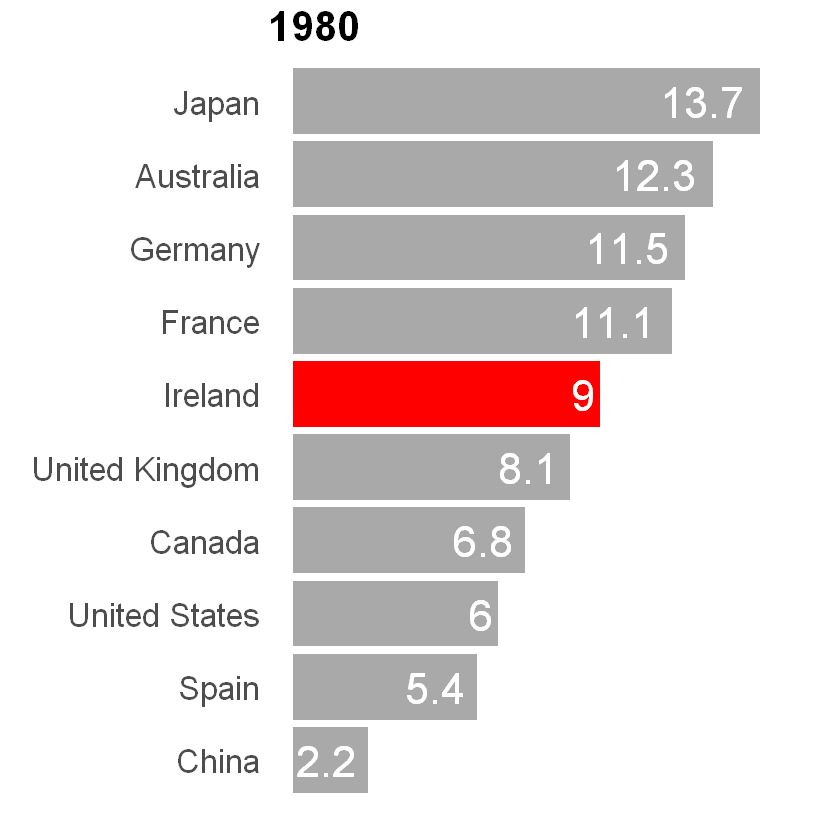

In [21]:
# Create a list of countries
countries <- c("Ireland", "Japan", "United States", "United Kingdom", "Canada", "Germany", "Spain", "Australia", "France", "China")

# Filter the dataframe to `Year` = 1980 and Country.Name included in the list above
beds_df_1980 <-
    beds_df %>%
    filter(Year == 1980, Country.Name %in% countries)

# Create a plot
ggplot(beds_df_1980, aes(x = Value, y = reorder(Country.Name, Value), fill = Country.Name)) +
    geom_bar(stat = "identity",
             fill = ifelse(beds_df_1980$Country.Name == "Ireland", "red", "dark gray")) + # Highlight Ireland in red
    geom_text(aes(label = Value), hjust = 1.2, color = "white", size = 9) + # Add labels within the bars
    labs(title = "1980", x = "", y = "") +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          legend.position = "none",
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 20),
          axis.ticks.x = element_blank(),
          axis.ticks.y = element_blank(),
          plot.title = element_text(size = 25, face = "bold")) +
    lims(x = c(0, 15))

Create a bar chart for the number of hospital beds per 1,000 population in 1990.

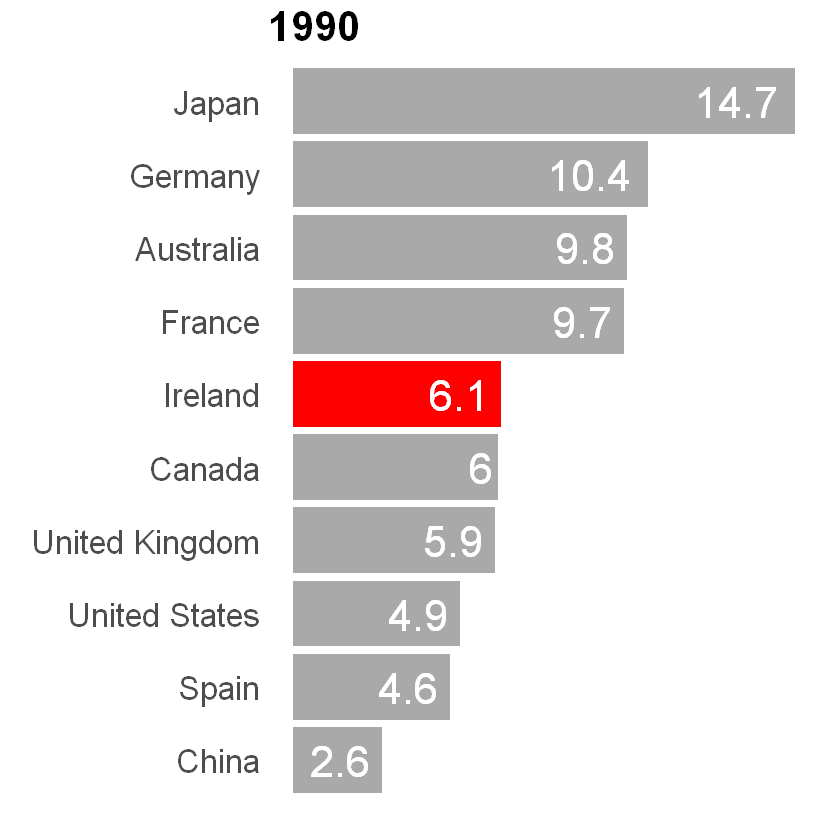

In [22]:
# Filter the dataframe to `Year` = 1990 and Country.Name included in `country`
beds_df_1990 <-
    beds_df %>%
    filter(Year == 1990, Country.Name %in% countries)

# Create a plot
ggplot(beds_df_1990, aes(x = Value, y = reorder(Country.Name, Value), fill = Country.Name)) +
    geom_bar(stat = "identity",
             fill = ifelse(beds_df_1990$Country.Name == "Ireland", "red", "dark gray")) + # Highlight Ireland in red
    geom_text(aes(label = Value), hjust = 1.2, color = "white", size = 9) + # Add labels within the bars
    labs(title = "1990", x = "", y = "") +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          legend.position = "none",
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 20),
          axis.ticks.x = element_blank(),
          axis.ticks.y = element_blank(),
          plot.title = element_text(size = 25, face = "bold")) +
    lims(x = c(0, 15))

Create a bar chart for the number of hospital beds per 1,000 population in 2000.

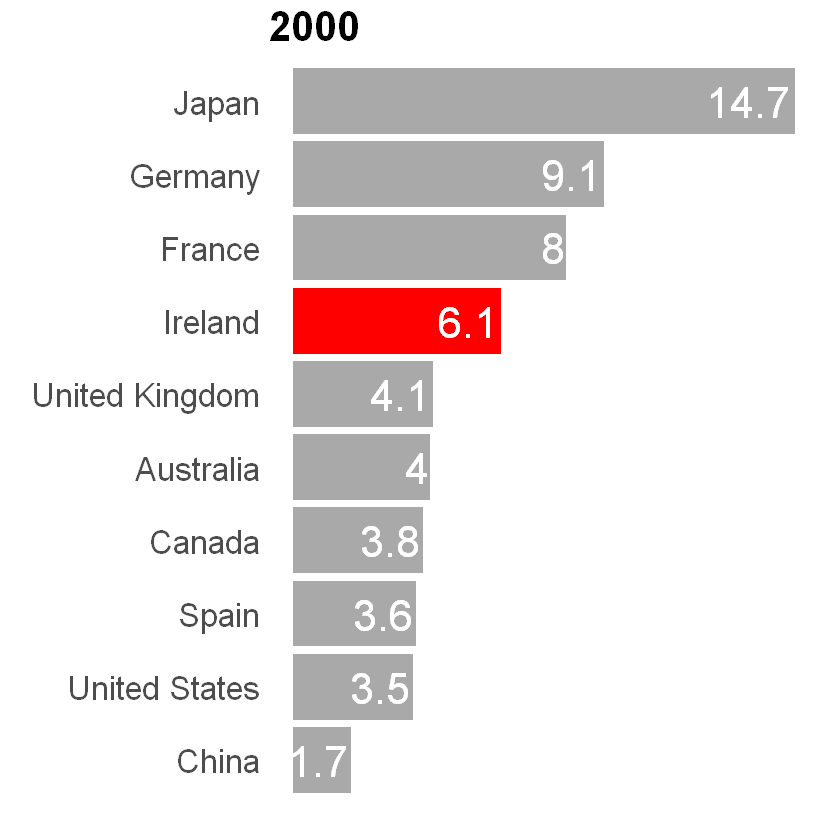

In [23]:
# Filter the dataframe to `Year` = 2000 and Country.Name included in `country`
beds_df_2000 <-
    beds_df %>%
    filter(Year == 2000, Country.Name %in% countries)

# Create a plot
ggplot(beds_df_2000, aes(x = Value, y = reorder(Country.Name, Value), fill = Country.Name)) +
    geom_bar(stat = "identity",
             fill = ifelse(beds_df_2000$Country.Name == "Ireland", "red", "dark gray")) + # Highlight Ireland in red
    geom_text(aes(label = Value), hjust = 1.05, color = "white", size = 9) + # Add labels within the bars
    labs(title = "2000", x = "", y = "") +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          legend.position = "none",
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 20),
          axis.ticks.x = element_blank(),
          axis.ticks.y = element_blank(),
          plot.title = element_text(size = 25, face = "bold")) +
    lims(x = c(0, 15))

Create a bar chart for the number of hospital beds per 1,000 population in 2010.

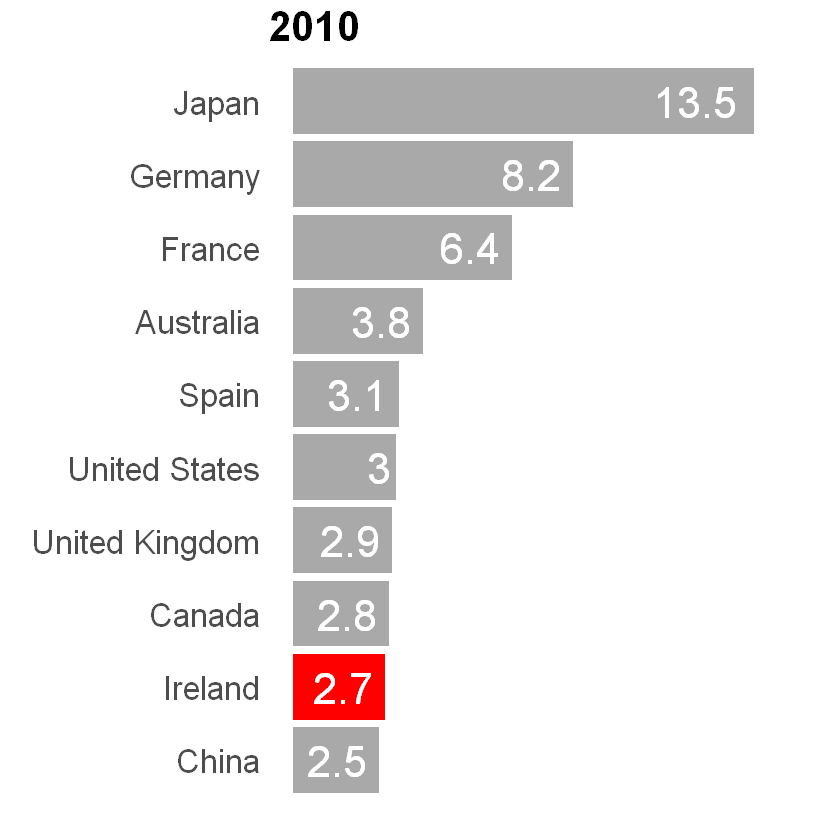

In [24]:
# Filter the dataframe to `Year` = 2010 and Country.Name included in `country`
beds_df_2010 <-
    beds_df %>%
    filter(Year == 2010, Country.Name %in% countries)

# Create a plot
ggplot(beds_df_2010, aes(x = Value, y = reorder(Country.Name, Value), fill = Country.Name)) +
    geom_bar(stat = "identity",
             fill = ifelse(beds_df_2010$Country.Name == "Ireland", "red", "dark gray")) + # Highlight Ireland in red
    geom_text(aes(label = Value), hjust = 1.2, color = "white", size = 9) + # Add labels within the bars
    labs(title = "2010", x = "", y = "") +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          legend.position = "none",
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 20),
          axis.ticks.x = element_blank(),
          axis.ticks.y = element_blank(),
          plot.title = element_text(size = 25, face = "bold")) +
        lims(x = c(0, 15))

Create a bar chart for the number of hospital beds per 1,000 population in 2018.

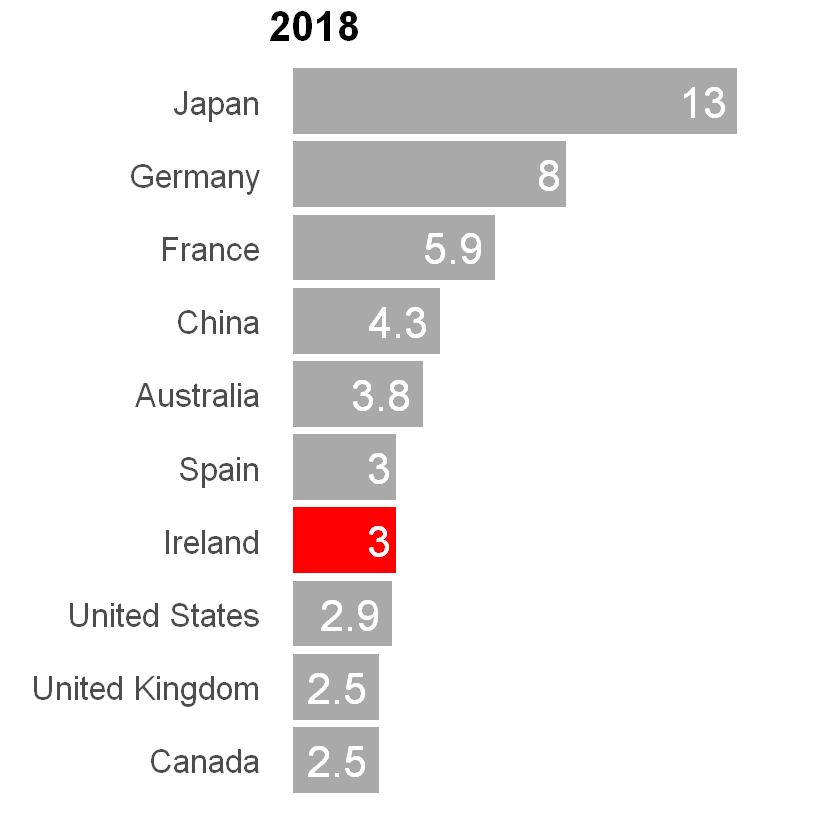

In [25]:
# Filter the dataframe to `Year` = 2018 and Country.Name included in `country`
beds_df_2018 <-
    beds_df %>%
    filter(Year == 2018, Country.Name %in% countries)

# Create a plot
ggplot(beds_df_2018, aes(x = Value, y = reorder(Country.Name, Value), fill = Country.Name)) +
    geom_bar(stat = "identity",
             fill = ifelse(beds_df_2018$Country.Name == "Ireland", "red", "dark gray")) + # Highlight Ireland in red
    geom_text(aes(label = Value), hjust = 1.2, color = "white", size = 9) + # Add labels within the bars
    labs(title = "2018", x = "", y = "") +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          legend.position = "none",
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 20),
          axis.ticks.x = element_blank(),
          axis.ticks.y = element_blank(),
          plot.title = element_text(size = 25, face = "bold")) +
    lims(x = c(0, 15))

### Previous Iteration

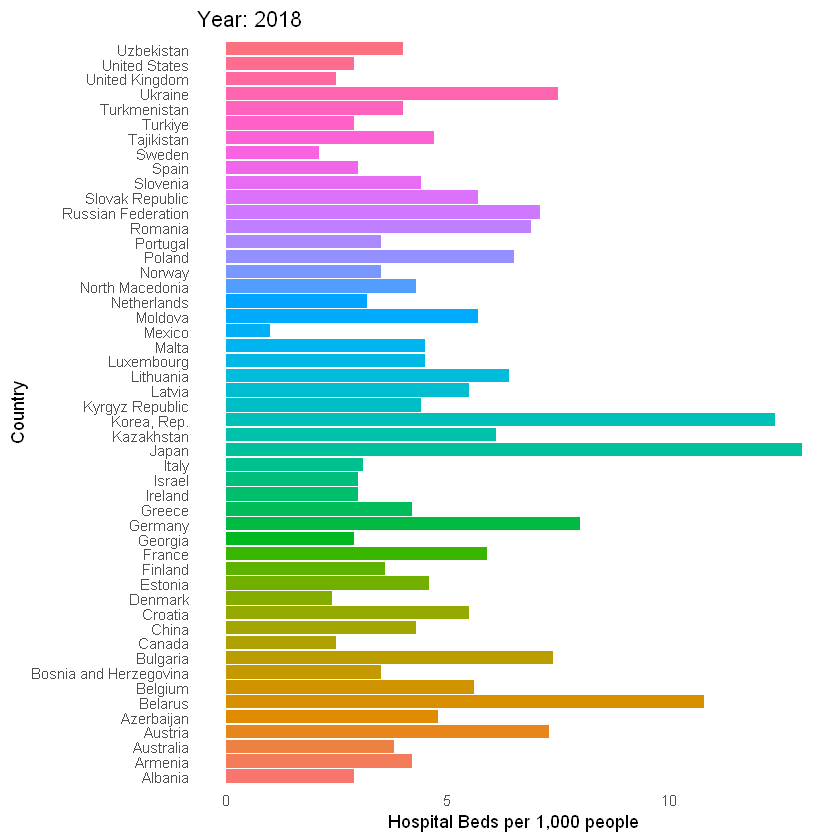

In [26]:
# Filter the dataframe to Year = 2018
beds_df_2018 <-
    beds_df %>%
    filter(Year == 2018)

# Create a plot
ggplot(beds_df_2018, aes(x = Value, y = Country.Name, Value, fill = Country.Name)) +
  geom_bar(stat = "identity") +
  labs(title = "Year: 2018", x = "Hospital Beds per 1,000 people", y = "Country") +
  theme_minimal() +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        legend.position = "none")

## Hospital Nurse Wages

Create a plot to compare the hospital nurses' wages with the coutries' average over time.

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4."
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


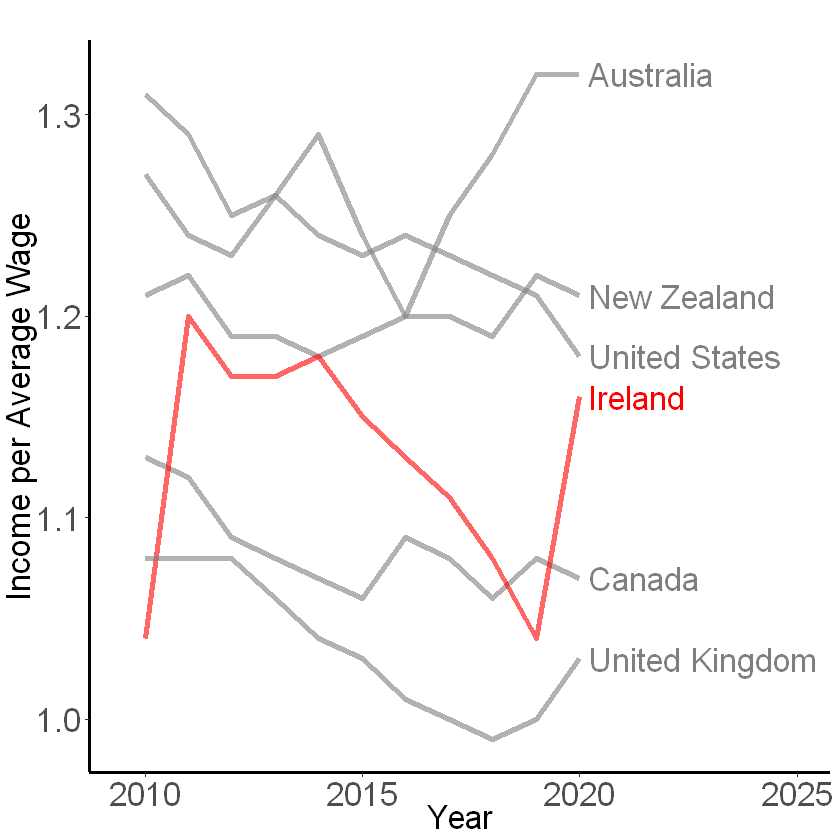

In [27]:
# Filter the dataframe to a selection of countries and create a line graph
wage1_df %>%
  ggplot(aes(x = Year, y = salary_usd, color = Country)) +
  geom_line(size = 1.5, alpha = 0.6) +
  geom_text(aes(label = ifelse(Year == max(Year), Country, "")),
            nudge_x = 0.2, hjust = 0, size = 7) +
  scale_color_manual(values = c("Ireland" = "red", "gray")) +
  labs(title = "", x = "Year", y = "Income per Average Wage") +
  guides(color = FALSE) +
  lims(x = c(2009.5, 2025)) +
  theme(
        axis.line = element_line(color = "black", size = 1),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 20),
        plot.title = element_text(size = 20),
        axis.title.y = element_text(size = 20),
        axis.title.x = element_text(size = 20)
  )

### Alternative Visualisation

Create a plot to compare the hospital nurses' wages with the coutries' average in 2010.

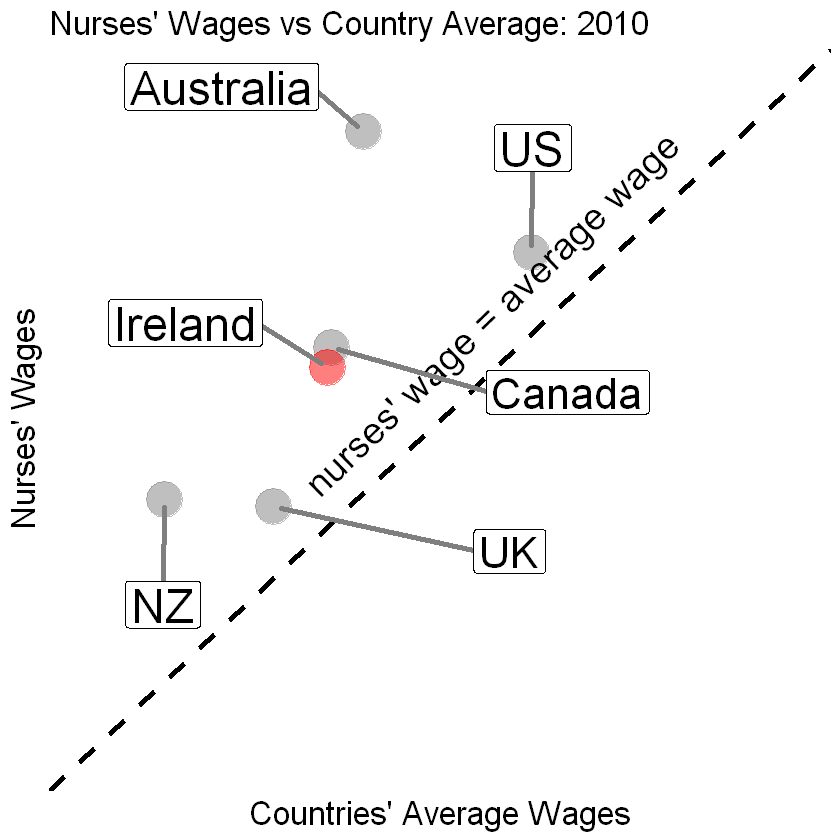

In [28]:
# Filter the dataframe to `Year` = 2010
wages_df_2010 <-
    nurse_df %>%
    filter(Year == 2010, Country %in% c("Australia", "NZ", "Ireland", "US", "UK", "Canada"))

# Create a plot to compare the hospital nurses' wages with the coutries' average in 2010
ggplot(wages_df_2010, aes(x = avg_usd, y = salary_usd, label = Country)) +
    geom_point(aes(color = Country), size = 10, alpha = 0.5) +
    scale_color_manual(values = c("Ireland" = "red", "gray")) + # Highlight Ireland in red
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", linewidth = 1.5) + # Add a diagonal line where nurses' wages = average wages
    annotate("text", x = max(wages_df_2010$avg_usd), y = max(wages_df_2010$avg_usd),
        label = "nurses' wage = average wage", hjust = 0.53, vjust = -1, color = "black", angle = 44, size = 8) +
    labs(title = "Nurses' Wages vs Country Average: 2010", x = "Countries' Average Wages", y = "Nurses' Wages") +
    theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        legend.position = "none",
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank(),
        plot.title = element_text(size = 20),
        axis.title.y = element_text(size = 20),
        axis.title.x = element_text(size = 20)) +
    lims(x = c(35000, 80000), y = c(35000, 80000)) +
    geom_label_repel(data = subset(wages_df_2010, Country %in% c("Australia", "Ireland")), # Add labels to the left
                  aes(label = Country),
                  box.padding   = 0.35,
                  point.padding = 0.5,
                  segment.color = 'grey50',
                  segment.size = 1.5,
                  size = 10,
                  nudge_x = -9000,
                  nudge_y = 3000) +
    geom_label_repel(data = subset(wages_df_2010, Country %in% c("UK", "Canada")), # Add labels to the right
                  aes(label = Country),
                  box.padding   = 0.35,
                  point.padding = 0.5,
                  segment.color = 'grey50',
                  segment.size = 1.5,
                  size = 9,
                  nudge_x = 15000,
                  nudge_y = -3000) +
    geom_label_repel(data = subset(wages_df_2010, Country == "NZ"), # Add labels below
                  aes(label = Country),
                  box.padding   = 0.35,
                  point.padding = 0.5,
                  segment.color = 'grey50',
                  segment.size = 1.5,
                  size = 10,
                  nudge_x = -100,
                  nudge_y = -7000) +
    geom_label_repel(data = subset(wages_df_2010, Country == "US"), # Add labels below
                  aes(label = Country),
                  box.padding   = 0.35,
                  point.padding = 0.5,
                  segment.color = 'grey50',
                  segment.size = 1.5,
                  size = 10,
                  nudge_x = 100,
                  nudge_y = 7000)

Create a plot to compare the hospital nurses' wages with the coutries' average in 2015.

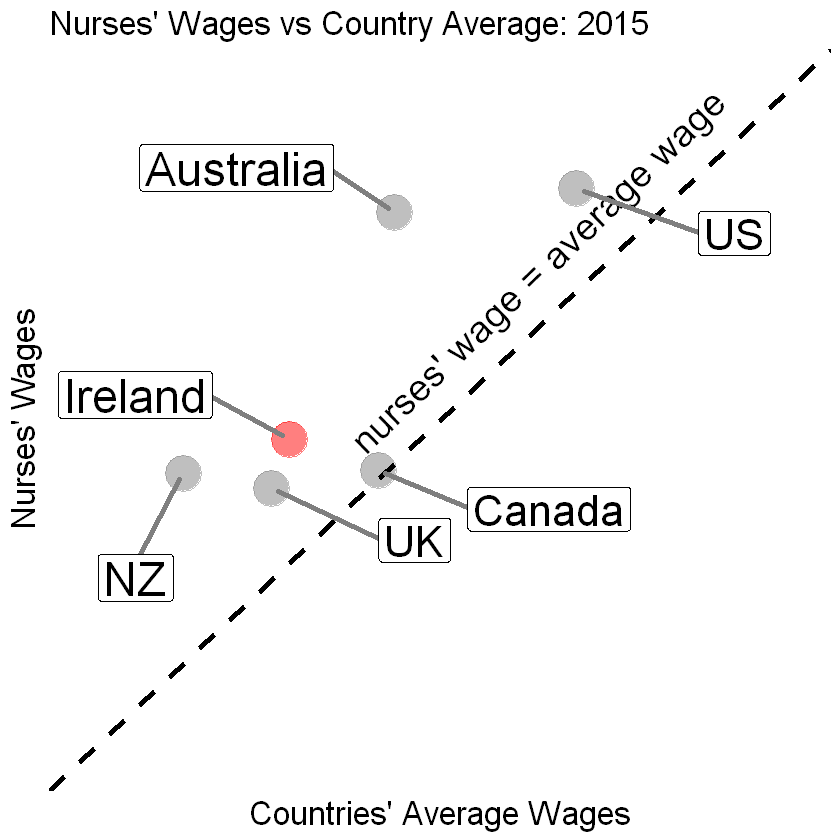

In [29]:
# Filter the dataframe to `Year` = 2015
wages_df_2015 <-
    nurse_df %>%
    filter(Year == 2015, Country %in% c("Australia", "NZ", "Ireland", "US", "UK", "Canada"))

# Create a plot to compare the hospital nurses' wages with the coutries' average in 2015
ggplot(wages_df_2015, aes(x = avg_usd, y = salary_usd, label = Country)) +
    geom_point(aes(color = Country), size = 10, alpha = 0.5) +
    scale_color_manual(values = c("Ireland" = "red", "gray")) + # Highlight Ireland in red
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", linewidth = 1.5) + # Add a diagonal line where nurses' wages = average wages
    annotate("text", x = max(wages_df_2015$avg_usd), y = max(wages_df_2015$avg_usd),
           label = "nurses' wage = average wage", hjust = 0.53, vjust = -1, color = "black", angle = 44, size = 8) +
    labs(title = "Nurses' Wages vs Country Average: 2015", x = "Countries' Average Wages", y = "Nurses' Wages") +
    theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        legend.position = "none",
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank(),
        plot.title = element_text(size = 20),
        axis.title.y = element_text(size = 20),
        axis.title.x = element_text(size = 20)) +
    lims(x = c(35000, 80000), y = c(35000, 80000))+
    geom_label_repel(data = subset(wages_df_2015, Country %in% c("Australia", "Ireland")), # Add labels to the left
                  aes(label = Country),
                  box.padding   = 0.35,
                  point.padding = 0.5,
                  segment.color = 'grey50',
                  segment.size = 1.5,
                  size = 10,
                  nudge_x = -10000,
                  nudge_y = 3000) +
    geom_label_repel(data = subset(wages_df_2015, Country %in% c("US", "UK", "Canada")), # Add labels to the right
                  aes(label = Country),
                  box.padding   = 0.35,
                  point.padding = 0.5,
                  segment.color = 'grey50',
                  segment.size = 1.5,
                  size = 9,
                  nudge_x = 10000,
                  nudge_y = -3000) +
    geom_label_repel(data = subset(wages_df_2015, Country == "NZ"), # Add labels below
                  aes(label = Country),
                  box.padding   = 0.35,
                  point.padding = 0.5,
                  segment.color = 'grey50',
                  segment.size = 1.5,
                  size = 10,
                  nudge_x = -3000,
                  nudge_y = -7000)

Create a plot to compare the hospital nurses' wages with the coutries' average in 2019.

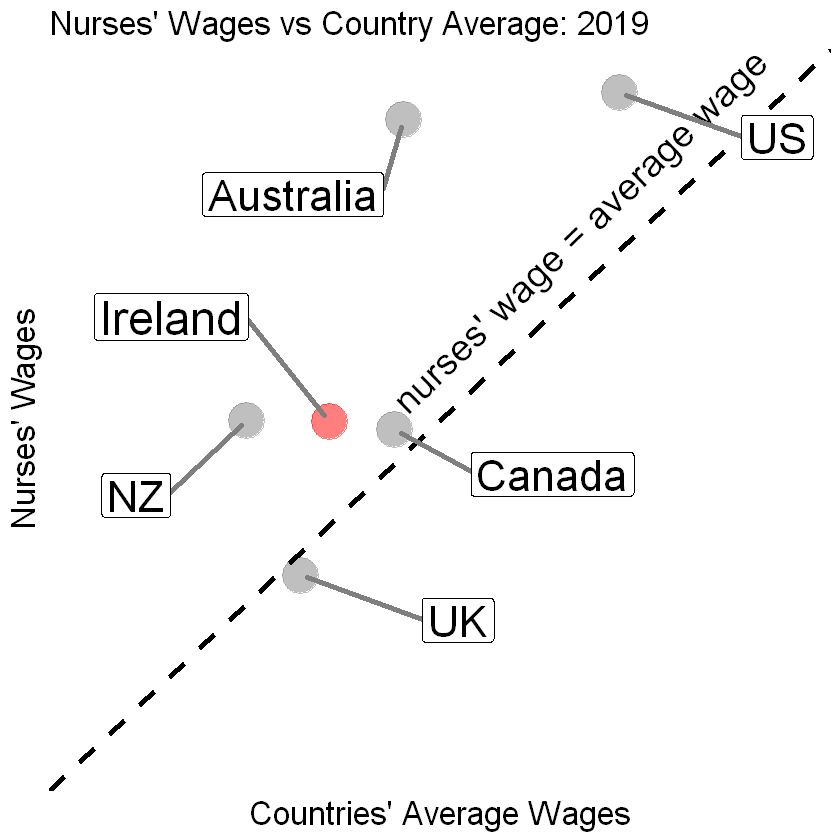

In [30]:
# Filter the dataframe to `Year` = 2019
wages_df_2019 <-
    nurse_df %>%
    filter(Year == 2019, Country %in% c("Australia", "NZ", "Ireland", "US", "UK", "Canada"))

# Create a plot to compare the hospital nurses' wages with the coutries' average in 2019
ggplot(wages_df_2019, aes(x = avg_usd, y = salary_usd, label = Country)) +
  geom_point(aes(color = Country), size = 10, alpha = 0.5) +
  scale_color_manual(values = c("Ireland" = "red", "gray")) + # Highlight Ireland in red
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", linewidth = 1.5) + # Add a diagonal line where nurses' wages = average wages
  annotate("text", x = max(wages_df_2019$avg_usd), y = max(wages_df_2019$avg_usd),
           label = "nurses' wage = average wage", hjust = 0.53, vjust = -1, color = "black", angle = 44, size = 8) +
  labs(title = "Nurses' Wages vs Country Average: 2019", x = "Countries' Average Wages", y = "Nurses' Wages") +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        legend.position = "none",
        axis.text.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank(),
        plot.title = element_text(size = 20),
        axis.title.y = element_text(size = 20),
        axis.title.x = element_text(size = 20)) +
  lims(x = c(35000, 80000), y = c(35000, 80000))+
  geom_label_repel(data = subset(wages_df_2019, Country %in% c("Ireland")), # Add labels to the left
                  aes(label = Country),
                  box.padding   = 0.35,
                  point.padding = 0.5,
                  segment.color = 'grey50',
                  segment.size = 1.5,
                  size = 10,
                  nudge_x = -10000,
                  nudge_y = 7000) +
  geom_label_repel(data = subset(wages_df_2019, Country %in% c("US", "UK", "Canada")), # Add labels to the right
                  aes(label = Country),
                  box.padding   = 0.35,
                  point.padding = 0.5,
                  segment.color = 'grey50',
                  segment.size = 1.5,
                  size = 9,
                  nudge_x = 10000,
                  nudge_y = -3000) +
    geom_label_repel(data = subset(wages_df_2019, Country %in% c("NZ", "Australia")), # Add labels to the right
                  aes(label = Country),
                  box.padding   = 0.35,
                  point.padding = 0.5,
                  segment.color = 'grey50',
                  segment.size = 1.5,
                  size = 9,
                  nudge_x = -7000,
                  nudge_y = -5000)

## Hospital Waiting List

Import the shapefile of administrative areas downloaded from [OSi National Statutory Boundaries 2019](https://data.gov.ie/en_GB/dataset/administrative-areas-osi-national-statutory-boundaries-2019-generalised-20m).

In [31]:
# Read the shapefile
shapefile_path <- here("Administrative_Areas_-_National_Statutory_Boundaries_-_2019_-_Generalised_20m", "Administrative_Areas___Gen_20m___2019.shp")
administrative <- st_read(shapefile_path)

Reading layer `Administrative_Areas___Gen_20m___2019' from data source 
  `C:\Users\Ayano\Downloads\D21125676_SPEC9995_Assignment2-20230804T100414Z-001\D21125676_SPEC9995_Assignment2\Administrative_Areas_-_National_Statutory_Boundaries_-_2019_-_Generalised_20m\Administrative_Areas___Gen_20m___2019.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 31 features and 13 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 416216.4 ymin: 519665.5 xmax: 734481.1 ymax: 966933.5
Projected CRS: IRENET95 / Irish Transverse Mercator


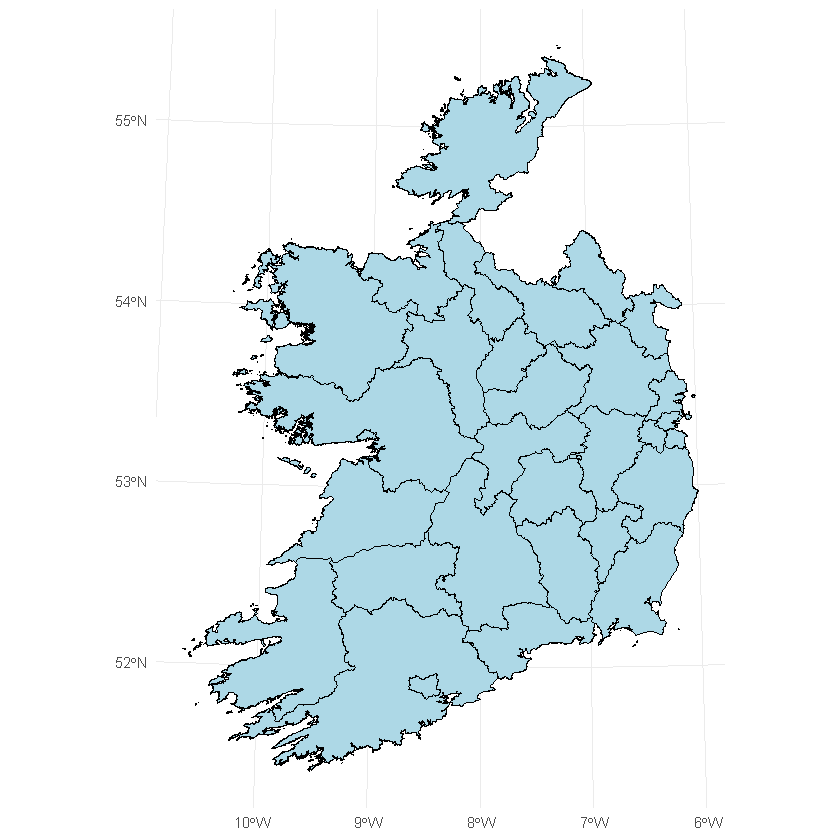

In [32]:
# Plot the map of Ireland
ggplot() +
    geom_sf(data = administrative, fill = "lightblue", color = "black") +
    theme_minimal()

Create a plot to show the size of the waiting list for each hospitals.

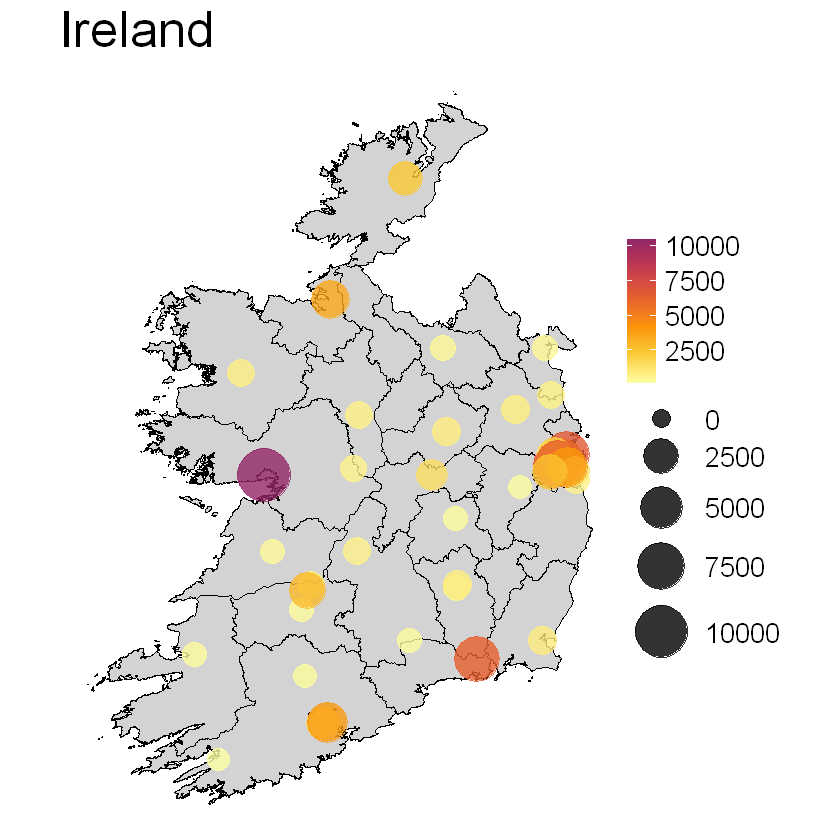

In [33]:
ggplot() +
    geom_sf(data = administrative, fill = "light gray", color = "black") + # Plot the map of Ireland
    geom_sf(data = hospitals_itm, aes(size = total_list, color = total_list), alpha = 0.8) + # Plot the hospitals coordinates
    coord_sf(crs = st_crs(administrative)) +  # Set plot limits to match the map of Ireland
    scale_size(range = c(5, 15), limits = c(0, 11000)) +  # Adjust the size scaling range
    scale_color_viridis_c(option = "inferno", direction = -1, begin = 0.4) +
    theme_void() +
    labs(title = "Ireland", fill = "") +
    theme(legend.title = element_blank(),
          legend.text = element_text(size = 16),
              plot.title = element_text(size = 30))

To resolve the occlusion problems in Dublin, create a separate plot with increased zoom for clarity.

In [34]:
# Filter administrative dataset to County Dublin
county_dublin <- subset(administrative, COUNTY == "DUBLIN")

# Print county_dublin
print(county_dublin)

Simple feature collection with 4 features and 13 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 696906.7 ymin: 715491.4 xmax: 732950.8 ymax: 766429.3
Projected CRS: IRENET95 / Irish Transverse Mercator
   ESRI_OID  CC_ID                               ENGLISH GAEILGE
1         1 265011                   DUBLIN CITY COUNCIL    <NA>
10       10 265003           SOUTH DUBLIN COUNTY COUNCIL    <NA>
11       11 265002                 FINGAL COUNTY COUNCIL    <NA>
22       22 265001 DUN LAOGHAIRE-RATHDOWN COUNTY COUNCIL    <NA>
              CONTAE COUNTY PROVINCE                                 GUID
1  Baile Átha Cliath DUBLIN Leinster 2ae19629-1433-13a3-e055-000000000001
10 Baile Átha Cliath DUBLIN Leinster 2ae19629-14a1-13a3-e055-000000000001
11 Baile Átha Cliath DUBLIN Leinster 2ae19629-14a0-13a3-e055-000000000001
22 Baile Átha Cliath DUBLIN Leinster 2ae19629-149f-13a3-e055-000000000001
   CENTROID_X CENTROID_Y      AREA SHAPE_Leng SHAPE_Area
1    716469.8   735

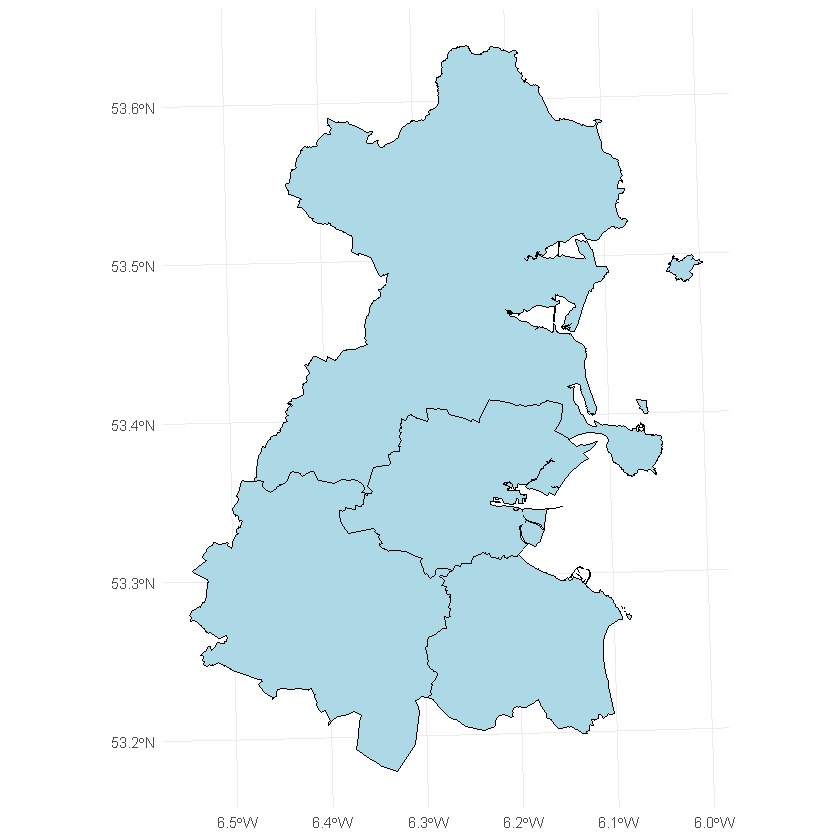

In [35]:
# Plot the map of County Dublin
ggplot() +
    geom_sf(data = county_dublin, fill = "lightblue", color = "black") +
    theme_minimal()

Filter the list of hospitals to only include those in County Dublin

In [36]:
# Filter hospitals_itm to points within county_dublin
dublin_points <- st_within(hospitals_itm$geometry, county_dublin$geometry)
hospitals_within_dublin <- hospitals_itm[dublin_points %in% 1:4, ]

Create a plot to show the size of the waiting list for each hospitals.

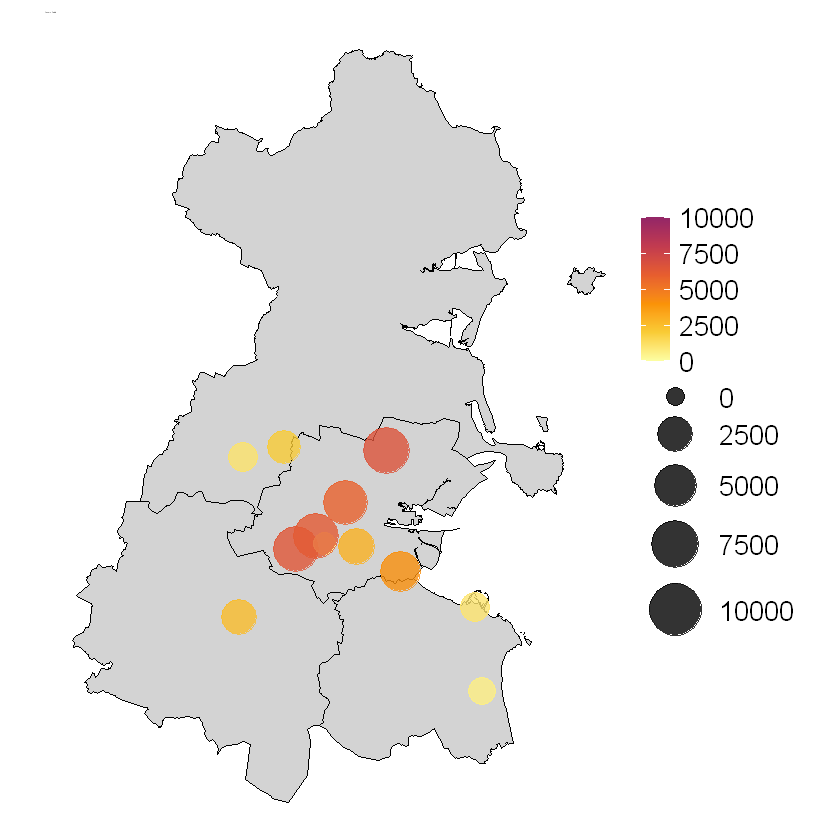

In [37]:
ggplot() +
    geom_sf(data = county_dublin, fill = "light gray", color = "black") + # Plot the map of Ireland
    geom_sf(data = hospitals_within_dublin, aes(size = total_list, color = total_list), alpha = 0.8) + # Plot the hospitals coordinates
    coord_sf(crs = st_crs(administrative)) +  # Set plot limits to match the map of Ireland
    scale_size(range = c(5, 15), limits = c(0, 11000)) +  # Adjust the size scaling range
    scale_color_viridis_c(option = "inferno", direction = -1, begin = 0.4, limits = c(0, 10000)) +
    theme_void() +
    labs(title = "County Dublin", fill = "") +
    theme(legend.title = element_blank(),
          legend.text = element_text(size = 16),
          plot.title = element_text(size = 0))

To resolve the occlusion problems in Dublin City, create a separate plot with increased zoom for clarity.

In [38]:
# Filter administrative dataset to Dublin City
dublin_city <- subset(administrative, ENGLISH == "DUBLIN CITY COUNCIL")

# Print dublin_city
print(dublin_city)

Simple feature collection with 1 feature and 13 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 707415.5 ymin: 728981.7 xmax: 725529 ymax: 741562.4
Projected CRS: IRENET95 / Irish Transverse Mercator
  ESRI_OID  CC_ID             ENGLISH GAEILGE            CONTAE COUNTY PROVINCE
1        1 265011 DUBLIN CITY COUNCIL    <NA> Baile Átha Cliath DUBLIN Leinster
                                  GUID CENTROID_X CENTROID_Y      AREA
1 2ae19629-1433-13a3-e055-000000000001   716469.8   735272.1 128350164
  SHAPE_Leng SHAPE_Area                       geometry
1   99214.02  128374254 MULTIPOLYGON (((707601.1 73...


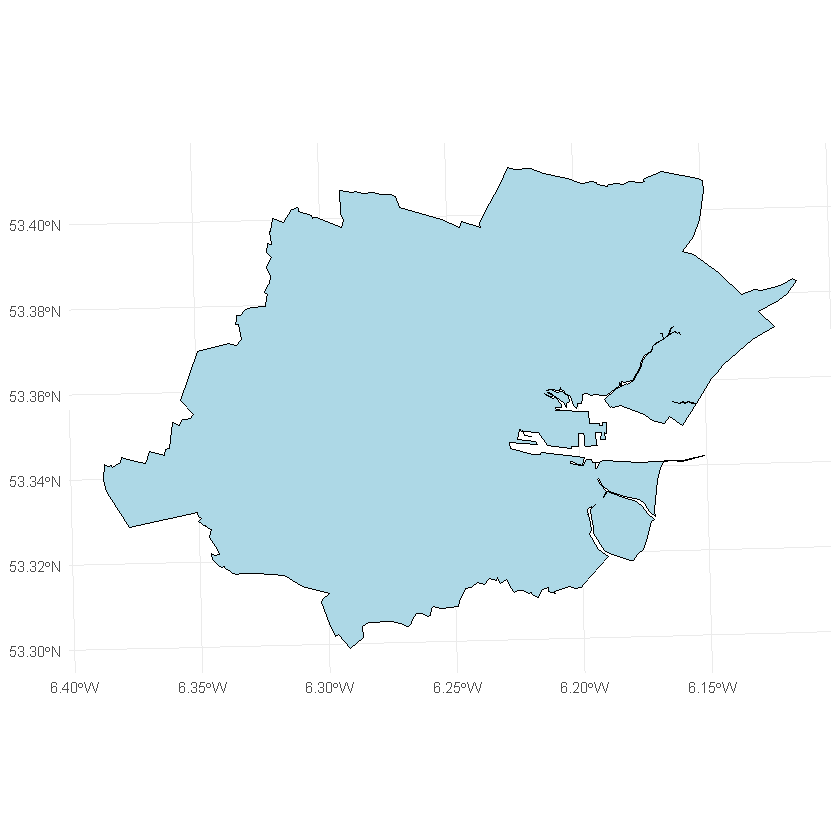

In [39]:
# Plot the map of County Dublin
ggplot() +
    geom_sf(data = dublin_city, fill = "lightblue", color = "black") +
    theme_minimal()

Filter the list of hospitals to only include those in Dublin City

In [40]:
# Filter hospitals_within_dublin to points within dublin_city
dublin_city_points <- st_within(hospitals_within_dublin$geometry, dublin_city$geometry)
hospitals_within_dublin_city <- hospitals_within_dublin[dublin_city_points %in% 1, ]

Create a plot to show the size of the waiting list for each hospitals.

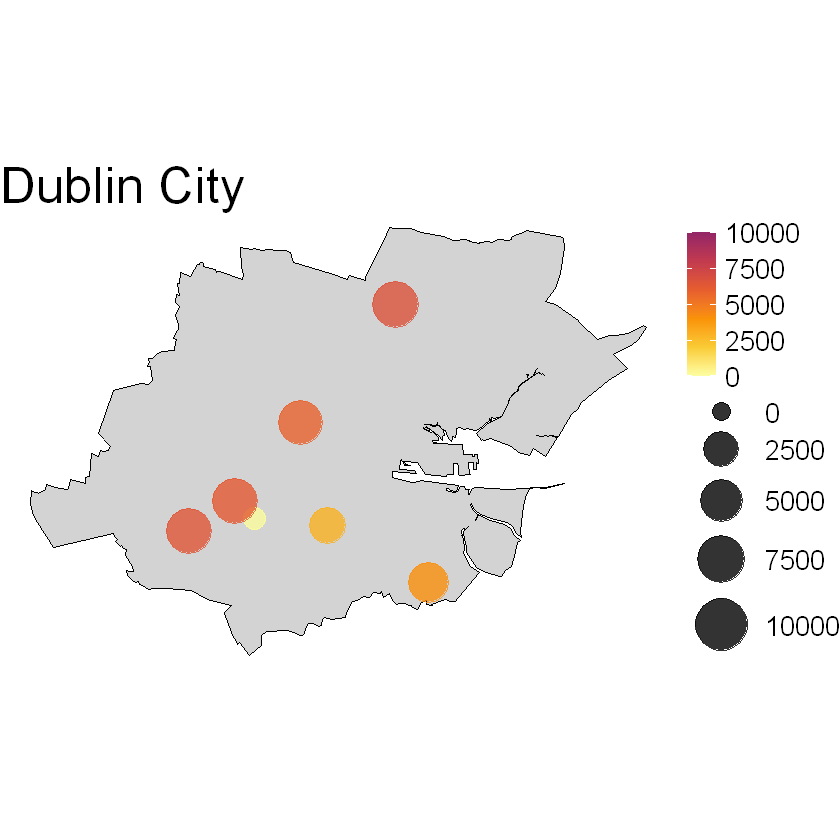

In [41]:
ggplot() +
    geom_sf(data = dublin_city, fill = "light gray", color = "black") + # Plot the map of Ireland
    geom_sf(data = hospitals_within_dublin_city, aes(size = total_list, color = total_list), alpha = 0.8) + # Plot the hospitals coordinates
    coord_sf(crs = st_crs(administrative)) +  # Set plot limits to match the map of Ireland
    scale_size(range = c(5, 15), limits = c(0, 11000)) +  # Adjust the size scaling range
    scale_color_viridis_c(option = "inferno", direction = -1, begin = 0.4, limits = c(0, 10000)) +
    theme_void() +
    labs(title = "Dublin City", fill = "") +
    theme(legend.title = element_blank(),
          legend.text = element_text(size = 16),
          plot.title = element_text(size = 30))

### Previous Iteration

The `maps` library does not have boundary data within the country and we cannot zoom in to resolve issues with occlusion.

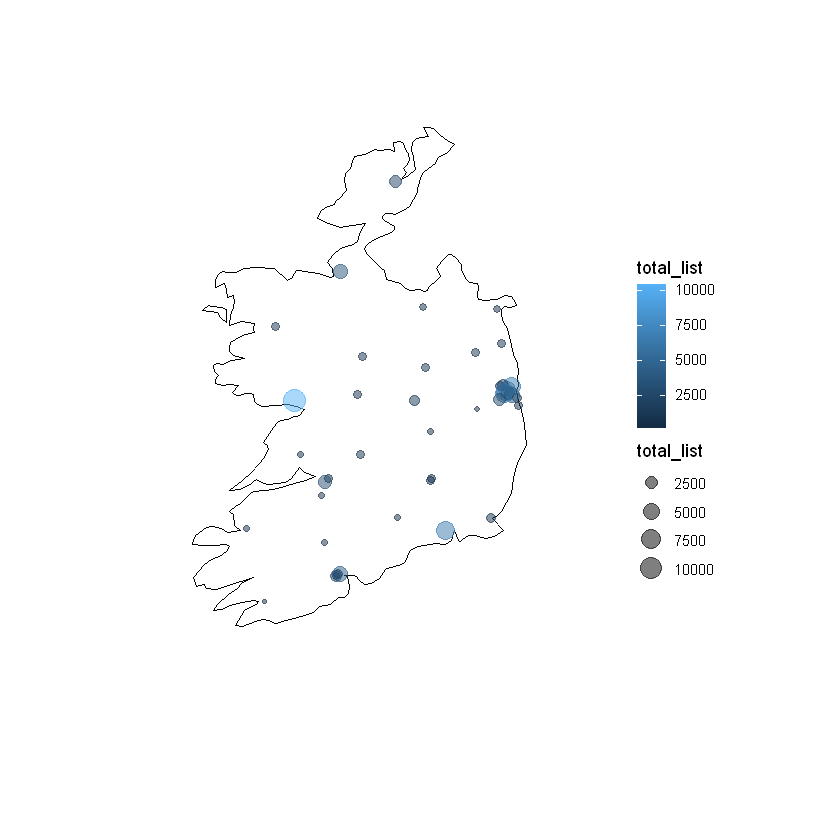

In [42]:
# Load map data for Ireland
ireland_map <- map_data("world", region = "Ireland")


ggplot() +
  geom_polygon(data = ireland_map, aes(x = long, y = lat, group = group), fill = "white", color = "black") +
  geom_point(data = hospitals_df, aes(x = longitude, y = latitude, size = total_list, color = total_list), alpha = 0.5) +
  coord_map("mercator", xlim = c(-11, -5), ylim = c(50, 56)) +
  theme_void()